In [1]:
import pandas as pd
from src.epl_proyection.etl import preprocessing
from src.epl_proyection.utils import ts_diagnostics
from src.epl_proyection.generate_analysis_table import generate_analysis
from src.epl_proyection.etl.preprocessing import generate_labor_data, run_preprocessing_pipeline

In [2]:
df = generate_labor_data(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras'])

In [ ]:
df_preprocessed = run_preprocessing_pipeline(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal'])

In [2]:
df = generate_analysis.generate_analysis_table(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal'],
                            path_activity_formal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_activity_formal='Ramas de actividad CIIU 4 A.C')

[I 2025-04-29 09:22:59,993] A new study created in memory with name: no-name-3819fa47-266a-4cc2-b3f3-fe5283505619
[I 2025-04-29 09:23:00,951] Trial 0 finished with value: 0.25988098067409016 and parameters: {'iterations': 362, 'learning_rate': 0.2497655739643347, 'depth': 5, 'l2_leaf_reg': 0.03842529541008457, 'bagging_temperature': 0.7740224934819302, 'random_strength': 0.9170019255864331}. Best is trial 0 with value: 0.25988098067409016.
[I 2025-04-29 09:23:01,636] Trial 1 finished with value: 0.02851155420678945 and parameters: {'iterations': 311, 'learning_rate': 0.02125599720916286, 'depth': 5, 'l2_leaf_reg': 0.005241091969670312, 'bagging_temperature': 0.16408941001102684, 'random_strength': 0.07315978097248876}. Best is trial 1 with value: 0.02851155420678945.
[I 2025-04-29 09:23:03,480] Trial 2 finished with value: 0.06873730018473515 and parameters: {'iterations': 737, 'learning_rate': 0.054351113784994035, 'depth': 5, 'l2_leaf_reg': 0.33372468337857875, 'bagging_temperature':

0:	learn: 0.0004932	total: 1.56ms	remaining: 1.55s
1:	learn: 0.0004890	total: 3.45ms	remaining: 1.7s
2:	learn: 0.0004848	total: 9.29ms	remaining: 3.05s
3:	learn: 0.0004807	total: 12.3ms	remaining: 3.03s
4:	learn: 0.0004767	total: 16.8ms	remaining: 3.3s
5:	learn: 0.0004726	total: 19.6ms	remaining: 3.2s
6:	learn: 0.0004687	total: 21ms	remaining: 2.95s
7:	learn: 0.0004646	total: 23.1ms	remaining: 2.83s
8:	learn: 0.0004606	total: 31.9ms	remaining: 3.47s
9:	learn: 0.0004568	total: 33.4ms	remaining: 3.27s
10:	learn: 0.0004529	total: 35.9ms	remaining: 3.19s
11:	learn: 0.0004490	total: 40.2ms	remaining: 3.27s
12:	learn: 0.0004453	total: 41.8ms	remaining: 3.14s
13:	learn: 0.0004415	total: 43.1ms	remaining: 3s
14:	learn: 0.0004378	total: 44.9ms	remaining: 2.91s
15:	learn: 0.0004340	total: 46.2ms	remaining: 2.81s
16:	learn: 0.0004304	total: 47.6ms	remaining: 2.72s
17:	learn: 0.0004267	total: 48.9ms	remaining: 2.64s
18:	learn: 0.0004231	total: 52.3ms	remaining: 2.67s
19:	learn: 0.0004195	total: 54

In [2]:
df_labor = preprocessing.run_preprocessing_pipeline(path_df2='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                                                    sheet_name_df2='Grandes dominios ',
                                                    sector=['Agricultura, ganadería, caza, silvicultura y pesca','Industrias manufactureras'],
                                                    cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                                                                'Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras', 'Formal', 'Informal'])

In [3]:
from src.epl_proyection.models.arimax.arimax_full_pipeline import predict_pea_arimax
df_labor_new = predict_pea_arimax(df_labor)
print(df_labor_new[['log_población en edad de trabajar (pet)', 'pred_log_pea', 'PredPea']].head())


   log_población en edad de trabajar (pet)  pred_log_pea  PredPea
0                                10.175046           NaN      NaN
1                                10.176532           NaN      NaN
2                                10.177874           NaN      NaN
3                                10.179354           NaN      NaN
4                                10.180799           NaN      NaN


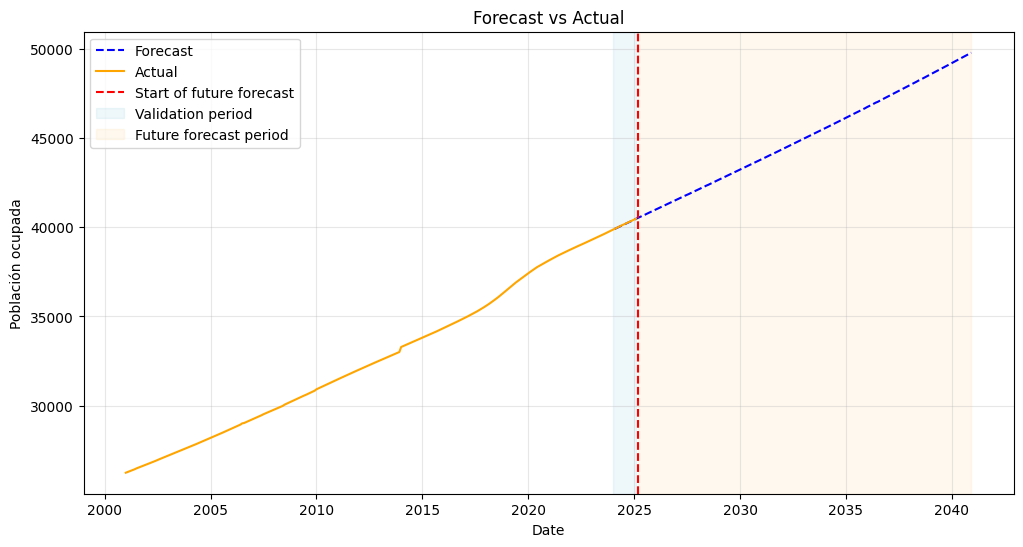

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_labor_new['ds'], df_labor_new['PredPea'], label='Forecast', color='blue', linestyle='--')
plt.plot(df_labor_new['ds'], df_labor_new['Población en edad de trabajar (PET)'], label='Actual', color='orange')
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', label='Start of future forecast')
plt.axvspan('2024-01-01', '2025-02-01', color='lightblue', alpha=0.2, label='Validation period')
plt.axvspan('2025-03-01', '2040-12-01', color='navajowhite', alpha=0.2, label='Future forecast period')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Población ocupada')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Forecast con ARIMAX

🔎 Diagnóstico de la serie original:
ADF Statistic: -4.7571
p-value: 0.0001
✅ La serie es estacionaria.


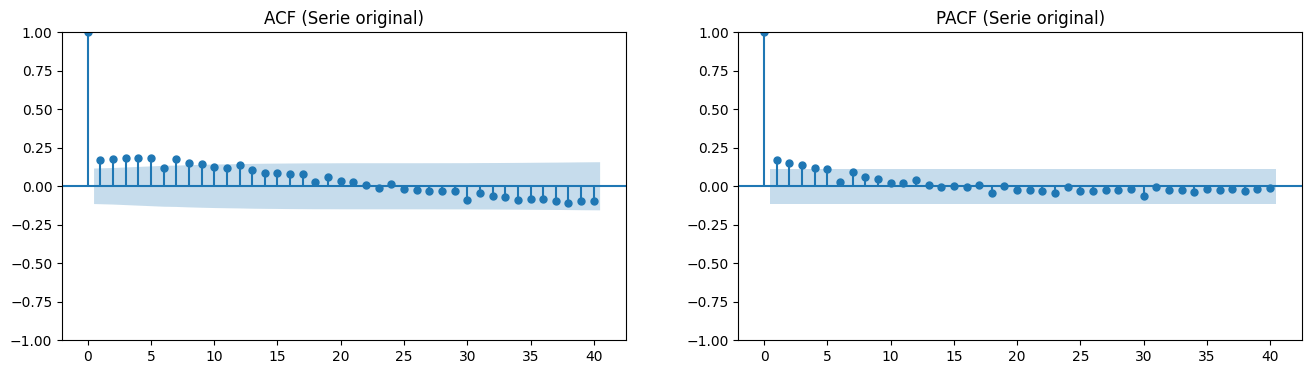

In [8]:
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población en edad de trabajar (pet)'])

# Entrenando Catboost

🔎 Diagnóstico de la serie original:
ADF Statistic: -5.3081
p-value: 0.0000
✅ La serie es estacionaria.


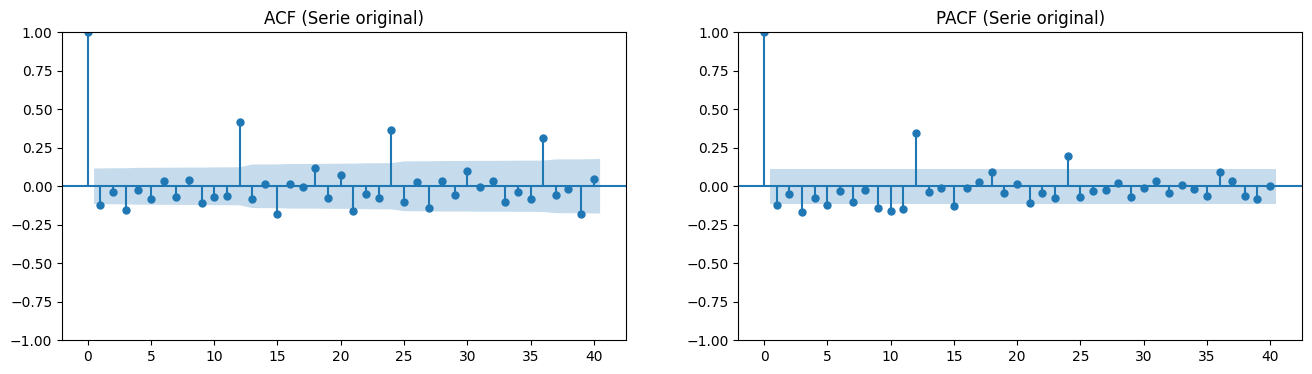

In [9]:
from src.epl_proyection.utils import ts_diagnostics
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población ocupada'])

In [10]:
from src.epl_proyection.models.catboost.catboost_main_pipeline import run_catboost_pipeline

# Correr todo el pipeline
df_final = run_catboost_pipeline(df_labor_new, n_trials = 30)

[I 2025-04-28 20:03:51,643] A new study created in memory with name: no-name-c417e083-cef5-43ff-9a27-1cd5f33d1cab
[I 2025-04-28 20:03:52,864] Trial 0 finished with value: 0.06361470754858226 and parameters: {'iterations': 664, 'learning_rate': 0.05184935697745912, 'depth': 6, 'l2_leaf_reg': 3.4757077439487607, 'bagging_temperature': 0.150475852590103, 'random_strength': 0.37544639422613046}. Best is trial 0 with value: 0.06361470754858226.
[I 2025-04-28 20:03:54,529] Trial 1 finished with value: 0.0560110573229169 and parameters: {'iterations': 690, 'learning_rate': 0.018039867690173805, 'depth': 7, 'l2_leaf_reg': 0.19857385011197595, 'bagging_temperature': 0.8315111128681353, 'random_strength': 0.6439120583317782}. Best is trial 1 with value: 0.0560110573229169.
[I 2025-04-28 20:03:58,634] Trial 2 finished with value: 0.06718341715681875 and parameters: {'iterations': 943, 'learning_rate': 0.04662863994873101, 'depth': 8, 'l2_leaf_reg': 0.03606745672439267, 'bagging_temperature': 0.47

0:	learn: 0.0004804	total: 2.4ms	remaining: 1.77s
1:	learn: 0.0004710	total: 5.25ms	remaining: 1.94s
2:	learn: 0.0004658	total: 6.52ms	remaining: 1.6s
3:	learn: 0.0004620	total: 8.09ms	remaining: 1.49s
4:	learn: 0.0004360	total: 9.81ms	remaining: 1.44s
5:	learn: 0.0004126	total: 10.5ms	remaining: 1.29s
6:	learn: 0.0004052	total: 11.2ms	remaining: 1.17s
7:	learn: 0.0003840	total: 12.4ms	remaining: 1.14s
8:	learn: 0.0003637	total: 14.1ms	remaining: 1.14s
9:	learn: 0.0003582	total: 15.6ms	remaining: 1.14s
10:	learn: 0.0003401	total: 16.3ms	remaining: 1.08s
11:	learn: 0.0003377	total: 16.9ms	remaining: 1.02s
12:	learn: 0.0003207	total: 20.1ms	remaining: 1.12s
13:	learn: 0.0003147	total: 21ms	remaining: 1.09s
14:	learn: 0.0003123	total: 21.7ms	remaining: 1.05s
15:	learn: 0.0003104	total: 22.3ms	remaining: 1.01s
16:	learn: 0.0002954	total: 23.4ms	remaining: 994ms
17:	learn: 0.0002934	total: 24ms	remaining: 962ms
18:	learn: 0.0002864	total: 24.5ms	remaining: 931ms
19:	learn: 0.0002726	total: 

In [ ]:
df_final.rename(columns={'PredPea': 'PredPETArimax',
                        'pred_pea_catboost':'PredPETCatboost'}, inplace=True)

Index(['YearMonth', 'Year', 'Month', 'workdays', 'weekends', 'holidays',
       'Población en edad de trabajar (PET)', 'Población ocupada',
       'Agricultura, ganadería, caza, silvicultura y pesca',
       'Industrias manufactureras', 'Formal', 'Informal', 'MonthNumber',
       'log_población en edad de trabajar (pet)',
       'logdiff_población en edad de trabajar (pet)', 'log_población ocupada',
       'logdiff_población ocupada',
       'log_agricultura, ganadería, caza, silvicultura y pesca',
       'logdiff_agricultura, ganadería, caza, silvicultura y pesca',
       'log_industrias manufactureras', 'logdiff_industrias manufactureras',
       'log_formal', 'logdiff_formal', 'log_informal', 'logdiff_informal',
       'negative_crashes', 'CommentBinaryVariable', 'proportion_formal_PET',
       'proportion_informal_PET', 'porportion_aggriculture_Occupied',
       'proportion_manufacturing_Occupied', 'ds', 'proportion_formal_PET_ma24',
       'proportion_informal_PET_ma24', 'porporti